In [3]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg

In [4]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [10, 5]

In [5]:
# from before
def phase_plot(genfn, xlim, ylim, nx, ny, ax, scale=False, **kwargs):
    X, Y = np.meshgrid(np.linspace(xlim[0], xlim[1], nx),
                       np.linspace(ylim[0], ylim[1], ny))
    X.shape = Y.shape = (np.prod(X.shape),)
    U, V = genfn(X, Y, **kwargs)
    if scale:
        q = ax.quiver(X, Y, U-X, V-Y, angles='xy', scale_units='xy', scale=1)
    else:
        q = ax.quiver(X, Y, U-X, V-Y, angles='xy')
    return q

def run_sim_2d(N0, M0, gen_fn, ngens, dtype='int', **kwargs):
    assert(len(N0) == len(M0))
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    M = np.empty((ngens, len(M0)), dtype=dtype)
    M[0, :] = M0
    for t in range(1, ngens):
        N[t, :], M[t, :] = gen_fn(N[t-1, :], M[t-1, :], **kwargs)
    return N, M


# Application to nonlinear systems

The theory above lets us analyze *nonlinear* systems by *linearizing* about fixed points.
We'll do this in a simple **predator-prey** model:

- $\theta$ : prey immigration rate
- $a$ : predator-prey contact (and consumption) rate
- $\epsilon$ : predator conversion efficiency
- $\delta$ : predator death rate

The deterministic differential equations are
$$\begin{aligned}
\frac{d n_1}{dt} &= \theta - a n_1 n_2 \\
\frac{d n_2}{dt} &= \epsilon a n_1 n_2 - \delta n_2 .
\end{aligned}$$

**Exercise:** which is the prey and which is the predator?

**Exercise:** Make a more realistic story for how much prey each predator eats.

## Stable points

To get stable points, we need to solve for when predator and prey numbers do not change.
Predator numbers do not change if $dn_2/dt = 0$, i.e., if
$$
   n_2 (\epsilon a n_1 - \delta) = 0 .
$$
This happens if either $n_2 = 0$ (naturally),
or if $n_1 = \delta / (\epsilon a)$.
Prey numbers do not change if $dn_1/dt = 0$, i.e., if
$$
  n_2 = \theta / (a n_1) .
$$
Putting this together, we have one equilibrium:
$$\begin{aligned}
  n_1^* &= \frac{\delta}{\epsilon a} \\
  n_2^* &= \frac{\theta \epsilon}{\delta} .
\end{aligned}$$


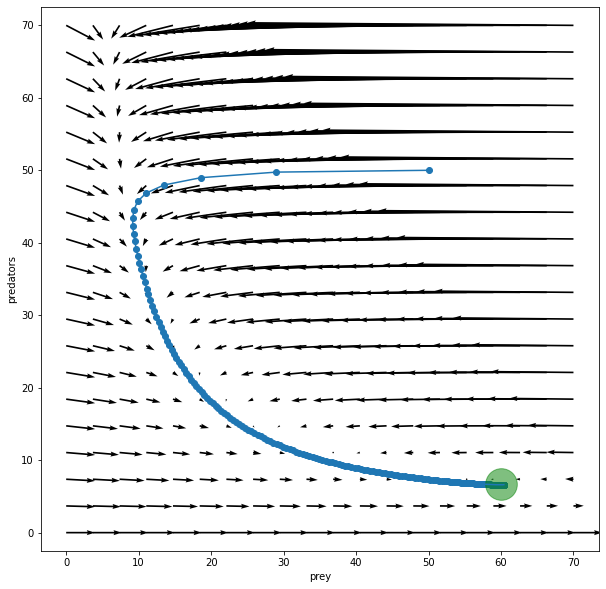

In [6]:
def pp_eqn(N, M, dt, theta, a, eps, delta):
    next_N = N + dt * (theta - a * N * M)
    next_M = M + dt * (eps * a * N * M - delta * M)
    return next_N, next_M

def pp_equil(theta, a, eps, delta):
    return delta / (eps * a), theta * eps / delta

pp_args = {'theta' : 40,
           'a' : 0.1,
           'eps' : 0.05,
           'delta' : 0.3}
equil = pp_equil(**pp_args)

tN, tM = run_sim_2d([50], [50], pp_eqn, 200, dtype='float',
                    dt=0.1, **pp_args)


plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
phase_plot(pp_eqn, xlim=[0, 70], ylim=[0, 70], nx=20, ny=20, scale=True,
           ax=ax, dt=0.1, **pp_args)
ax.plot(tN, tM)
ax.scatter(tN, tM)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
ax.axis('equal')
plt.xlabel("prey")
plt.ylabel("predators");


### Local approximations

Ok, so what's going on near that equilibrium?
Let's reparameterize, so that $x_1$ is the deviation of numbers of prey from equilibrium,
and $x_2$ is the deviation of the number of predators:
$$\begin{aligned}
  n_1 &= n_1^* + x_1 \\
  n_2 &= n_2^* + x_2
\end{aligned}$$
The deterministic differential equations are, rewritten:
$$\begin{aligned}
\frac{d x_1}{dt} &= \theta - a (n_1^* + x_1) (n_2^* + x_2) \\
                 &= \theta - a n_1^* n_2^* - a (n_1^* x_2 + x_1 n_2^* + x_1 x_2) \\
                 &= - a (n_1^* x_2 + x_1 n_2^* + x_1 x_2) \\
                 &\approx - a (n_1^* x_2 + x_1 n_2^*) \\
                 &= - \frac{a \epsilon \theta }{ \delta } x_1 - \frac{ \delta }{ \epsilon } x_2 \\
\frac{d x_2}{dt} &= \left(\epsilon a (n_1^* + x_1) - \delta \right) (n_2^* + x_2) \\
                 &= \left(\epsilon a n_1^* - \delta\right) n_2^* + \epsilon a x_1 n_2^* - \delta x_2 + a x_1 x_2 \\
                 &\approx \left(\epsilon a n_1^* - \delta \right) x_2 + \epsilon a x_1 n_2^* \\
                 &= \frac{\epsilon^2 a \theta }{ \delta} x_1 .
\end{aligned}$$
The steps here are (1) use the fact that $(n_1^*, n_2^*)$ is an equilibrium (so some terms become zero),
and (2) only keeping terms to *first order* in $x_1$ and $x_2$.

This says that, if the system is near the nonzero equilibrium,
it acts like the *linear* system whose matrix is
$$
  J = \begin{bmatrix} 
    - \frac{a \epsilon \theta }{ \delta } & - \frac{ \delta }{ \epsilon } \\
     \frac{\epsilon^2 a \theta }{ \delta} & 0 
   \end{bmatrix}
$$

i.e.,
$$
  \frac{dx}{dt} = J x
$$

In [7]:
def pp_approx_eqn(N, M, dt, theta, a, eps, delta):
    equil = pp_equil(theta, a, eps, delta)
    J = np.array([[- a * eps * theta / delta,     - delta / eps], 
                  [eps * eps * a * theta / delta, 0]])
    old_X = N - equil[0]
    old_Y = M - equil[1]
    dX, dY = dt * J @ np.row_stack([old_X, old_Y])
    next_N = N + dX
    next_M = M + dY
    return next_N, next_M

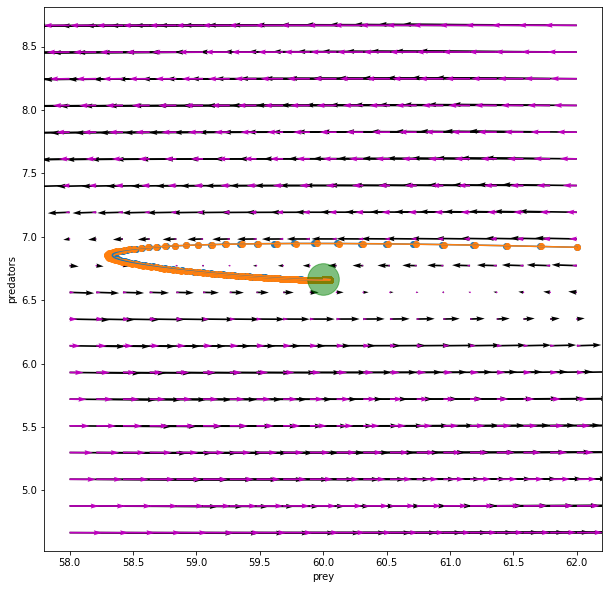

In [8]:
W = 2.0
tN, tM = run_sim_2d([equil[0] + W], [equil[1] + W/8], pp_eqn, 200, dtype='float',
                    dt=0.1, **pp_args)
aN, aM = run_sim_2d([equil[0] + W], [equil[1] + W/8], pp_approx_eqn, 200, dtype='float',
                    dt=0.1, **pp_args)

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
phase_plot(pp_eqn, xlim=[equil[0] - W, equil[0] + W], 
           ax=ax, ylim=[equil[1] - W, equil[1] + W], nx=20, ny=20, scale=True,
           dt=0.1, **pp_args)
q = phase_plot(pp_approx_eqn, xlim=[equil[0] - W, equil[0] + W], 
               ax=ax, ylim=[equil[1] - W, equil[1] + W], nx=20, ny=20, scale=False,
               dt=0.1, **pp_args)
q.set(color = 'm')
ax = fig.gca()
ax.plot(tN, tM)
ax.scatter(tN, tM)
ax.plot(aN, aM)
ax.scatter(aN, aM)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
ax.axis('equal')
plt.xlabel("prey")
plt.ylabel("predators");

Here's a different set of parameters:

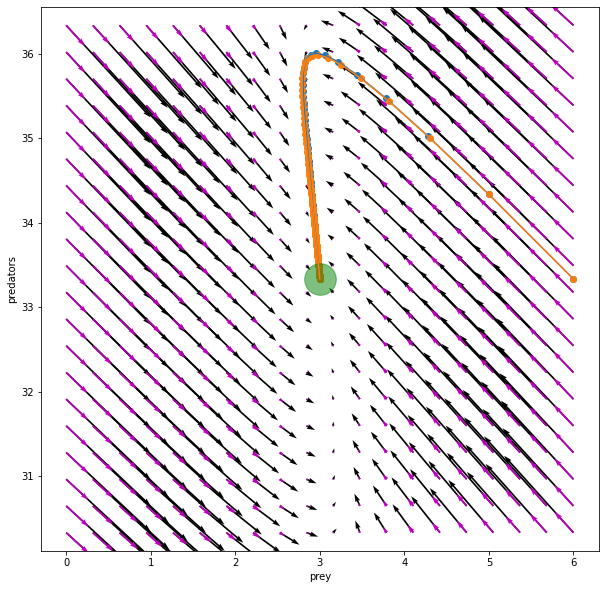

In [9]:
pp_args2 = {'theta' : 10,
           'a' : 0.1,
           'eps' : 1.0,
           'delta' : 0.3}
equil = pp_equil(**pp_args2)

W = 3.0
tN, tM = run_sim_2d([equil[0] + W], [equil[1]], pp_eqn, 200, dtype='float',
                    dt=0.1, **pp_args2)
aN, aM = run_sim_2d([equil[0] + W], [equil[1]], pp_approx_eqn, 200, dtype='float',
                    dt=0.1, **pp_args2)

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
phase_plot(pp_eqn, xlim=[equil[0] - W, equil[0] + W], 
           ax=ax, ylim=[equil[1] - W, equil[1] + W], nx=20, ny=20, scale=True,
           dt=0.1, **pp_args2)
q = phase_plot(pp_approx_eqn, xlim=[equil[0] - W, equil[0] + W], 
               ax=ax, ylim=[equil[1] - W, equil[1] + W], nx=20, ny=20, scale=False,
               dt=0.1, **pp_args2)
q.set(color = 'm')
ax = fig.gca()
ax.plot(tN, tM)
ax.scatter(tN, tM)
ax.plot(aN, aM)
ax.scatter(aN, aM)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
ax.axis('equal')
plt.xlabel("prey")
plt.ylabel("predators");

## Stability analysis

Let's see now how the eigenvalues of $J$ change as we adjust $\delta$.

- If all eigenvalues have negative Real part, the equilibrium is a *sink*.
- If any eigenvalues have nonzero Imaginary part, the equilibrium has an oscillatory component.

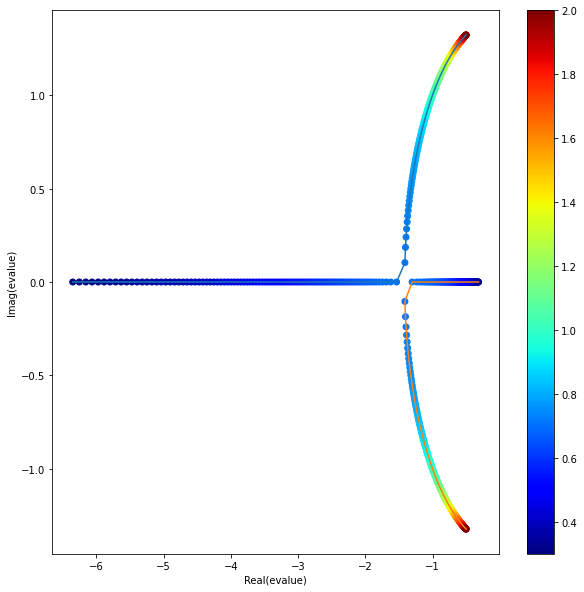

In [12]:
def pp_eigs(theta, a, eps, delta):
    J = np.array([[-a * eps * theta / delta, - delta / eps], [eps * eps * a * theta / delta, 0]])
    evals, evecs = linalg.eig(J)
    return evals


pp_args = {'theta' : 40,
           'a' : 0.1,
           'eps' : 0.5,
           'delta' : 0.3}

dvals = np.linspace(0.3, 2.0, 400)
J_eigs = np.array([pp_eigs(pp_args['theta'], pp_args['a'], pp_args['eps'], delta)
                   for delta in dvals])

fig, ax = plt.subplots()
ax.plot(np.real(J_eigs[:, 0]), np.imag(J_eigs[:, 0]))
sc = ax.scatter(np.real(J_eigs[:, 0]), np.imag(J_eigs[:, 0]), 
                c=dvals, cmap=matplotlib.cm.jet, label='delta')
ax.plot(np.real(J_eigs[:, 1]), np.imag(J_eigs[:, 1]))

sc = ax.scatter(np.real(J_eigs[:, 1]), np.imag(J_eigs[:, 1]), 
                c=dvals, cmap=matplotlib.cm.jet, label='delta')
fig.colorbar(sc)
plt.xlabel("Real(evalue)")
plt.ylabel("Imag(evalue)");

In [ ]:
print(pp_args)
pp_eigs(**pp_args)

**Ah-ha:** there is some value of $\delta$ at which point the two eigenvalues hit each other,
then move off in the imaginary axis!  For $\delta$ above that point,
the system should oscillate as it converges.

## Homework 8 option 2:

Find the value of $\delta$ at which the top eigenvalue of $J$ leaves the real line, and check that the system oscillates above it, and not below.

In [ ]:
# This should oscillate

pp_args3 = {'theta' : 10,
           'a' : 0.1,
           'eps' : 1.0,
           'delta' : 1.95}
equil = pp_equil(**pp_args3)

W = 2.0
tN, tM = run_sim_2d([equil[0] + W], [equil[1]], pp_eqn, 200, dtype='float',
                    dt=0.1, **pp_args3)
aN, aM = run_sim_2d([equil[0] + W], [equil[1]], pp_approx_eqn, 200, dtype='float',
                    dt=0.1, **pp_args3)

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
phase_plot(pp_eqn, xlim=[equil[0] - W, equil[0] + W], 
           ax=ax, ylim=[equil[1] - W, equil[1] + W], nx=20, ny=20, scale=True,
           dt=0.1, **pp_args3)
q = phase_plot(pp_approx_eqn, xlim=[equil[0] - W, equil[0] + W], 
               ax=ax, ylim=[equil[1] - W, equil[1] + W], nx=20, ny=20, scale=False,
               dt=0.1, **pp_args3)
q.set(color = 'm')
ax = fig.gca()
ax.plot(tN, tM)
ax.scatter(tN, tM)
ax.plot(aN, aM)
ax.scatter(aN, aM)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
ax.axis('equal')
plt.xlabel("prey")
plt.ylabel("predators");
